<h1 style="text-align: center;">
A model that can distinguish between female and male faces - if neither it is labeled "Unknown" (referred to as "Image")
</h1>

## NOTE: The comments in this notebook comes from training using ~1000 images of each label, so if one gets different results, even with the same amount of images that is to be expected. 

## Setting up the environment 

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os
sys.path.append("../../FastAi")
# Only necessary when running both ROS and fast.ai at the same computer
#sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [3]:
print (os.listdir("../../FastAi"))

['.git', '.gitignore', '.travis.yml', 'activate', 'CODE-OF-CONDUCT.md', 'courses', 'docs', 'environment-cpu.yml', 'environment.yml', 'fastai', 'LICENSE', 'MANIFEST', 'MANIFEST.in', 'pytest.ini', 'README.md', 'requirements.txt', 'Scripts', 'setup.cfg', 'setup.py', 'tests', 'tutorials']


In [4]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Downloading the images

Downloading the images using a program from https://github.com/hardikvasa/google-images-download and running it through bash scripting locally in the notebook. More possible configurations, such as multiple searchwords, different combinations, etc., but this is enough for now. 

To run this method: <br>
#### Using pip
<div class="alert alert-block alert-info">
$ pip install google_images_download
</div> <br>
 Manually using CLI
 <div class="alert alert-block alert-info">
 \$ git clone https://github.com/hardikvasa/google-images-download.git <br>
 \$ cd google-images-download && sudo python setup.py install
 </div> <br>  
 Manually using UI
 <div class="alert alert-block alert-info">
Go to the repo on github ==> Click on *Clone or Download* ==> Click on *Download ZIP* and save it on your local disk. </div>

<div class="alert alert-block alert-warning">
**NOTE** To download > 100 images, please see GitHub <br>
Involves downloading Chromedriver <br>
</div>

### The specified searchwords will be the classes

### Storing the data in such a way that it matches standard PyTorch folder setup
> <div class="alert alert-block alert-info">
*data/train/className* <br />
*data/valid/className*
</div>

#### If error messages on chromedriver (downloading > 100 images), try downloading a different version 
```http://chromedriver.chromium.org/downloads) ```

#### Or verify that the path to the executable is correct
Tip is to use ```os.listdir()```

In [ ]:
chromedriver_path = "../../chromedriver_win32/chromedriver"

### If one has a valid chromedriver (path), add 
```--chromedriver $chromedriver_path```

at the end of 

```! googleimagesdownload --keywords $searchword --format $form --limit $lim --output_directory $directory```

### Or copy this line:

```! googleimagesdownload --keywords $searchword --format $form --limit $lim --output_directory $directory --chromedriver $chromedriver_path```

In [5]:
def download_images(searchword, form="jpg", lim=100, directory= "data"):
    if not os.path.isdir(directory):
        ! mkdir $directory
    ! googleimagesdownload --keywords $searchword --format $form --limit $lim --output_directory $directory 
    src_path = os.path.join(directory, searchword)
    if not os.path.isdir(src_path):
        ! mkdir $src_path
    dst_train_path = os.path.join(directory, "train")
    dst_valid_path = os.path.join(directory, "valid")
    if not os.path.isdir(dst_train_path and dst_valid_path):
        ! mkdir $dst_train_path
        ! mkdir $dst_valid_path
    train_search_folder = os.path.join(dst_train_path, searchword)
    valid_search_folder = os.path.join(dst_valid_path, searchword)
    if not os.path.isdir(train_search_folder and valid_search_folder):
        ! mkdir $train_search_folder
        ! mkdir $valid_search_folder
    counter = 0
    number_of_files = len(os.listdir(src_path))
    train_ratio = number_of_files*0.7 
    for file in os.listdir(src_path):
        src = os.path.join(src_path, file)
        end = (searchword + "." + str(counter) + "." + form)
        dst_end = os.path.join(searchword, end)
        if(counter <= train_ratio):
            dst = os.path.join(dst_train_path, dst_end)
        else:
            dst = os.path.join(dst_valid_path, dst_end)
        os.replace(src, dst)
        counter = counter + 1
    delete_dir = os.path.join(directory, searchword)
    ! rmdir /s /q $delete_dir

### Specifying the desired classes to classify
Because of how the image downloader is set up the word *Image* is used instead of *Unknown*

In [6]:
class1_name = "Female_face"
class2_name = "Male_face"
class3_name = "Image"

In [7]:
%%capture
download_images(class1_name, lim=10);
download_images(class2_name, lim=10);
download_images(class3_name, lim=10);

# Deep Learning
> Utilizing the FastAi framework

## Setting up the necessary PATH to data

In [8]:
PATH = "data"
os.listdir(PATH)

['train', 'valid']

In [9]:
train_path = os.path.join(PATH, "train")
valid_path = os.path.join(PATH, "valid")
print(os.listdir(train_path))
print(os.listdir(valid_path))

['Female_face', 'Image', 'Male_face']
['Female_face', 'Image', 'Male_face']


Possible to get a nicer output of the items in directories? 

In [10]:
class1_path_train = os.path.join(train_path, class1_name)
class2_path_train = os.path.join(train_path, class2_name)
class3_path_train = os.path.join(train_path, class3_name)

class1_path_valid = os.path.join(valid_path, class1_name)
class2_path_valid = os.path.join(valid_path, class2_name)
class3_path_valid = os.path.join(valid_path, class3_name)

In [11]:
print("Training folder: ")
print("Class1: " , os.listdir(class1_path_train)[:2])
print("Class2: " , os.listdir(class2_path_train)[:2])
print("Class3: " , os.listdir(class3_path_train)[:2])

print("Validation folder: ")
print("Class1: " , os.listdir(class1_path_valid)[:2])
print("Class2: " , os.listdir(class2_path_valid)[:2])
print("Class3: " , os.listdir(class3_path_valid)[:2])

Training folder: 
Class1:  ['Female_face.0.jpg', 'Female_face.1.jpg']
Class2:  ['Male_face.0.jpg', 'Male_face.1.jpg']
Class3:  ['Image.0.jpg', 'Image.1.jpg']
Validation folder: 
Class1:  ['Female_face.8.jpg', 'Female_face.9.jpg']
Class2:  ['Male_face.7.jpg', 'Male_face.8.jpg']
Class3:  ['Image.8.jpg', 'Image.9.jpg']


In [12]:
file = os.listdir(class2_path_train)[:1]
file

['Male_face.0.jpg']

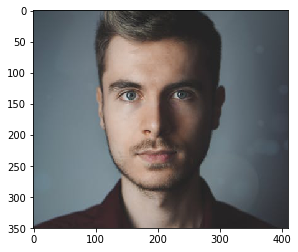

In [13]:
full_file_path = os.path.join(class2_path_train, file[0])
img = plt.imread(full_file_path)
plt.imshow(img)

In [14]:
img.shape

(350, 410, 3)

In [15]:
img[:4, :4]

array([[[61, 74, 82],
        [61, 74, 82],
        [61, 74, 82],
        [62, 75, 83]],

       [[61, 74, 82],
        [61, 74, 82],
        [62, 75, 83],
        [62, 75, 83]],

       [[61, 74, 82],
        [62, 75, 83],
        [62, 75, 83],
        [62, 75, 83]],

       [[62, 75, 83],
        [62, 75, 83],
        [62, 75, 83],
        [63, 76, 84]]], dtype=uint8)

## Uncomment if needing to resize images 

> <div class="alert alert-block alert-warning">
Possible problems with it storing them in *tmp* folder
</div>

In [ ]:
#from sklearn import metrics 
#
#def get_data(sz, bs):
#    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
#    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
#    return data if sz > 300 else data.resize(340, 'tmp');

### Setting training values

In [16]:
arch = resnet34
sz = 299 # One of two standards for ImageNet (224)
bs = 64 

### Data Augmentation
When training for multiple epochs, the model will start overfitting, which basically means the model is learning to recognizing specific images in the training set, rather than generalizing such that it is relevant for other images than just the ones in the training set. 

One quick fix is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

In [17]:
augmentation = transforms_side_on

## Training

In [ ]:
%%capture
tfms = tfms_from_model(arch, sz, aug_tfms=augmentation, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=1)
learn = ConvLearner.pretrained(arch, data, ps=0.4)
learn.fit(1e-3, 1)

## Problems because of non-valid image types

> <div class="alert alert-block alert-info">
Can use module *imghdr* to verify image types
</div>

In [ ]:
import imghdr
imghdr.what(full_file_path)

### Loop through dataset to remove invalid images 

> <div class="alert alert-block alert-info">
But first, interesting to see amount of lost data
</div>

In [ ]:
print(class1_name + " training files: " , len(os.listdir(class1_path_train)))
print(class2_name + " training files: " , len(os.listdir(class2_path_train)))
print(class3_name + " training files: " , len(os.listdir(class3_path_train)))
print(class1_name + " validation files: " , len(os.listdir(class1_path_valid)))
print(class2_name + " validation files: " , len(os.listdir(class2_path_valid)))
print(class3_name + " validation files: " , len(os.listdir(class3_path_valid)))

In [ ]:
file_paths = [class1_path_train, 
              class2_path_train,
              class3_path_train,
              class1_path_valid, 
              class2_path_valid,
            class3_path_valid]
for path in file_paths:
    for files in os.listdir(path):
        file_path = os.path.join(path, files)
        if imghdr.what(file_path) != 'jpeg':
            os.remove(file_path);

In [ ]:
print(class1_name + " training files: " , len(os.listdir(class1_path_train)))
print(class2_name + " training files: " , len(os.listdir(class2_path_train)))
print(class3_name + " training files: " , len(os.listdir(class3_path_train)))
print(class1_name + " validation files: " , len(os.listdir(class1_path_valid)))
print(class2_name + " validation files: " , len(os.listdir(class2_path_valid)))
print(class3_name + " validation files: " , len(os.listdir(class3_path_valid)))

### NOTE: Tried to switch image type from *None* to *JPEG* 
> <div class="alert alert-block alert-info">
In order to minimize data loss. 
</div>

## Updated data set

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, ps=0.5)

In [ ]:
learn.fit(1e-2, 3)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1)

# Locate optimal learning rate

In [ ]:
learn.lr_find()
learn.sched.plot()

## Optimal learning rate is slightly lower than 1e-2

In [ ]:
lr = 0.04

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

> Unfreezing the first layers, and checking if there is a new optimal learning rate

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 0.03

In [ ]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

### Checking accuracy on validation set using _Test Time Augmentation_
Using the same transforms method as specified *tfms*, which provides the model with 4 additional images. 

The model uses these 5 images (4 transforms, 1 original) and outputs the average classification between these 5 images. 

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

accuracy_np(probs, y)

### Saving the model

In [ ]:
learn.save("Resnet34_multiclass")

## Visualizing the Data Augmentation
When training for multiple epochs, the model will start overfitting, which basically means the model is learning to recognizing specific images in the training set, rather than generalizing such that it is relevant for other images than just the ones in the training set. 

One quick fix is to effectively create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

In [ ]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [ ]:
ims = np.stack([get_augs() for i in range(6)])

In [ ]:
plots(ims, rows=2)

# Can se that the model is *overfitting*

### When *validation loss* >> *training* 

> <div class="alert alert-block alert-info">
Possible solutions: Data Augmentation, Increase dropout, unfreeze and use differential learning rates
</div>

## Not very good results: 82% accuracy and overfitting

### Initially: increase dropout

In [ ]:
learn = ConvLearner.pretrained(arch, data, ps=0.65)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.lr_find()
learn.sched.plot()

> Nothing interesting. <br>
> Trying to unfreeze.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(1e-3, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.lr_find()
learn.sched.plot()

### Again using _Test Time Augmentation_ to improve the accuracy

In [ ]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)

accuracy_np(probs, y)

In [ ]:
learn.save("Resnet34_multiclass")

# Conclusion

> ### Suboptimal, but considering the data set it's all one can expect

Though, interesting to see if a more powerful model will have an impact
## Trying with a different model: *Resnext50*

In [ ]:
arch = resnext50
sz = 299 # One of two standards for ImageNet (224)
bs = 32 

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)
learn = ConvLearner.pretrained(arch, data, ps=0.6)

In [ ]:
learn.fit(1e-3, 3)

In [ ]:
learn.lr_find()
learn.sched.plot()

> No clear optimal learning rate

In [ ]:
learn.fit(1e-4, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.lr_find()
learn.sched.plot()

> Again, no clear cut optimal learning rate, but seems that 1e-2 is the best choice

In [ ]:
lr = 1e-2

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save("ResNext50_multiclass")

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

# Conclusion

> ## 83,4 % accuracy is sligthly better than what Resnet34 gave us
> ### Considering the data set the result is not too bad